# INFO 204 Lab 11 - Optimisation

***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

You've done a lot of supervised learning in this paper. A vital part of supervised learning is a search for a model `f(x, theta)` that best fits the observed data, usually obtained by "fitting" a set of model parameters `theta`. Underlying this fitting process is _optimisation_, where the values of `theta` are identified such that they minimise a given _cost function_ (for example, the cost function in regression might be the squared error of the residuals).

In some cases of supervised learning, we cannot easily identify the model through "normal" means. In such cases, we may have to resort to directly defining the optimisation process and using an optimisation method to solve the problem for us. In this lab, you will:

1. See how optimisation can be used to discover a model that predicts _multiple_ response values from the same input.
2. See how the parameters for a non-linear model may be fit through optimisation.

## Precursors

For this lab, we will require the following libraries and components:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from scipy.optimize import least_squares

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV

## Example 1: Multiple Response Values

Consider the following data:

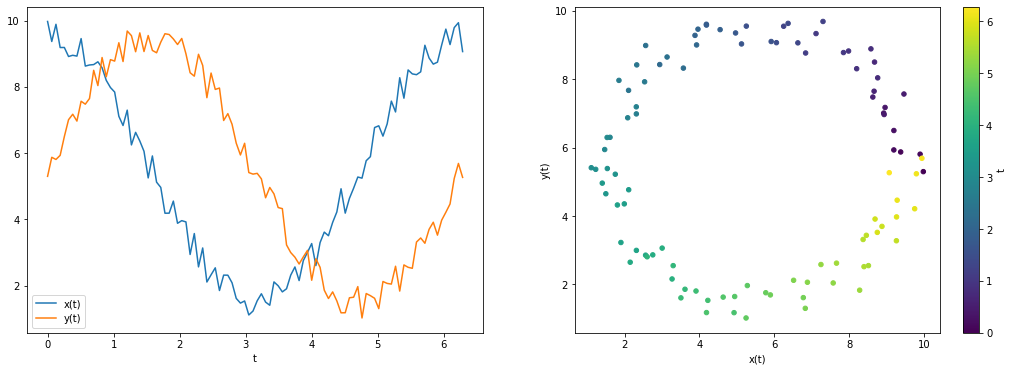

In [2]:
rng = np.random.default_rng(1234)
noise = 1
cx, cy, r = 5, 5, 4

t = np.linspace(0, 2 * np.pi, num=100)
x = cx + r * np.cos(t) + rng.uniform(0, noise, size=t.shape)
y = cy + r * np.sin(t) + rng.uniform(0, noise, size=t.shape)

observed_data = pd.DataFrame({ 't' : t, 'x(t)' : x, 'y(t)' : y })

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 2, 1)
observed_data.plot(x='t', ax=ax)

ax = fig.add_subplot(1, 2, 2)
observed_data.plot.scatter(x='x(t)', y='y(t)', c='t', cmap='viridis', ax=ax)

plt.show()

As usual, we assume that we don't "know" how the data was generated, we only have it as it was observed. Unlike all the previous examples thatyou have seen, in this particular data set we have two response variables (i.e., we need to simultaneously predict two values from our input(s)).

Based on what you have seen in 204 so far, you may be tempted to model this as two problems, and use a typical supervised learning approach to solve it. For example, you may model this as a pair of decision trees and fit these through cross validation:

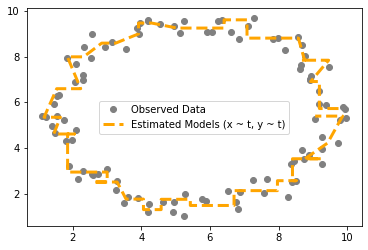

In [31]:
x, y, t = observed_data['x(t)'].values.reshape(-1, 1), observed_data['y(t)'].values.reshape(-1, 1), observed_data['t'].values.reshape(-1, 1)

kf = KFold(n_splits=5)
tune_grid = { 'min_samples_split' : np.logspace(1, 6, 6, base=2).astype(int) }

mdl_tx = GridSearchCV(DecisionTreeRegressor(random_state=0), tune_grid, cv=kf, n_jobs=-1).fit(t, x)
mdl_ty = GridSearchCV(DecisionTreeRegressor(random_state=0), tune_grid, cv=kf, n_jobs=-1).fit(t, y)

plt.plot(x, y, 'o', color='grey', label='Observed Data')
plt.plot(mdl_tx.predict(t), mdl_ty.predict(t), '--', color='orange', lw=3, label='Estimated Models (x ~ t, y ~ t)')
plt.legend()
plt.show()

While this looks successful, there's a serious problem with this approach: the two models that were developed, `mdl_tx` and `mdl_ty` were developed independently of each other. Therefore, they are strictly two separate models that just happen to work together here, but there's also every chance that the resulting models would have been incompatible.

Rather than model independently, we could model this in a single process with two responses. For example, there's a clear underlying circular arrangement of the data, so we could possible model this as a circle with center $(c_x, c_y)$ and radius $r$. The model then becomes:
$$
f(t, c_x, c_y, r) = { c_x + r \times \cos\left(t\right), c_y + r \times \sin\left(t\right) }
$$

As can be seen, the two responses now share a common radius $r$.

**<span style="color: #ce2227;">TASK 1: </span>** Define a function `circle` that takes four arguments, `t`, `cx`, `cy`, and `radius`. This function will implement the model described above that returns two response values for a given `t`. To return the two values, use a numpy array (i.e., `np.array`) and use the numpy trig functions for sine and cosine (i.e., `np.sin` and `np.cos`).

In [21]:
def circle(t, cx, cy, radius):
   
   a = cx  + radius * np.cos(t)
   b= cy + radius *np.sin(t)
   ouput = np.array([a,b])
   
   return ouput

If the model has been defined correctly, the plot generated by the code below will be a perfect circle:

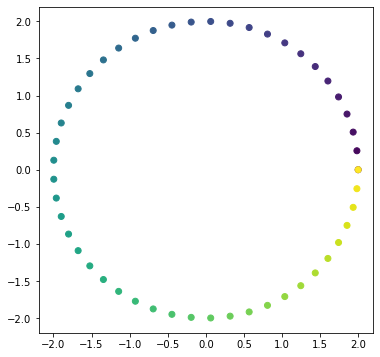

In [22]:
t = np.linspace(0, 2*np.pi)


points = circle(t, 0, 0, 2)

fig = plt.figure(figsize=(6, 6))
plt.scatter(points[0], points[1], c=t)
plt.show()

Let's now see how good this model is, just using the "mean" of the observed data:

5.54535714238377 5.488092437232508 4.4332029550711


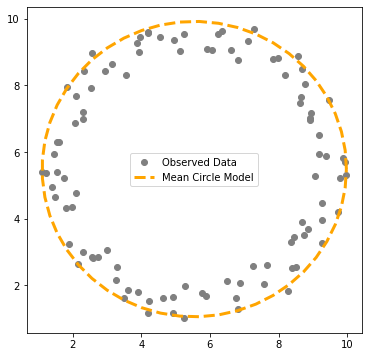

In [23]:
cx, cy, r = np.mean(x), np.mean(y), (np.max(x) - np.min(x)) / 2
mean_circle_points = circle(t, cx, cy, r)
print(cx, cy, r)

fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o', color='grey', label='Observed Data')
plt.plot(mean_circle_points[0], mean_circle_points[1], '--', color='orange', lw=3, label='Mean Circle Model')
plt.legend()
plt.show()

This seems to catch the perimeter of the observations quite well, but that isn't reflective of the centre of the data. To get the "true" model, we'll need to be a little bit more thorough.


Now, with the model defined, it's time to find an optimal configuration of it in terms of it's center ($c_x$ and $c_y$) and radius $r$. The function that we will optimise will be of the residuals of our model, as shown below:

In [24]:
def residuals(theta, mdl, xy, t):
    return (xy - mdl(t, *theta)).flatten()

Essentially, our optimisation process will aim to reduce the residuals of our model to zero.

We will now solve (optimise) the problem through _nonlinear least squares_. Rather than define this ourselves, we will use the readily available [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) function. As the name suggests, this approach will attempt to use a family of methods collectively called [_nonlinear least squares_](https://en.wikipedia.org/wiki/Non-linear_least_squares), which are an extension of the linear least squares method used in standard linear regression:

In [32]:
args = (circle, np.array([x, y]), t)

res_lsq = least_squares(residuals, np.array([0, 0, 0]), loss='linear', args=args)

print(res_lsq)

 active_mask: array([0., 0., 0.])
        cost: 9.28336628590991
         fun: array([ 0.48798727, -0.10855061,  0.43439848, -0.2273239 , -0.1701543 ,
       -0.3714607 , -0.24815053, -0.17181064,  0.47324581, -0.22773166,
       -0.05098032,  0.11722487,  0.37026401,  0.36964003,  0.17995739,
        0.16410145,  0.23909655, -0.27483142, -0.32647481,  0.37088995,
       -0.44039456,  0.1821274 ,  0.16863226,  0.10735621, -0.44458797,
        0.47197725, -0.06790606,  0.02467704, -0.50583635, -0.25873833,
        0.34746625, -0.08672245,  0.22282773,  0.40811156, -0.36136403,
        0.47655198, -0.33420352,  0.42279389, -0.43117218, -0.05053029,
        0.30961564, -0.23889809,  0.34862245,  0.45548898,  0.32038954,
       -0.07278341, -0.15141653, -0.03945742, -0.43008037, -0.29564648,
        0.01423665,  0.21096973, -0.07321607, -0.21642419,  0.42570259,
        0.22970972, -0.04887914, -0.06319318,  0.22638745,  0.33602632,
       -0.22523945,  0.21525926,  0.29151169,  0.37055168

As can be seen, the object returned by `least_squares` contains a lot of information. The two things that we are most interested in are the `success` attribute (here, True denotes a successful convergence of the algorithm), and `x`, which is the vector of our model parameters that minimised our cost function (residuals).

Let's compare the difference between the optimsed model and the "mean" model that we developed earlier:

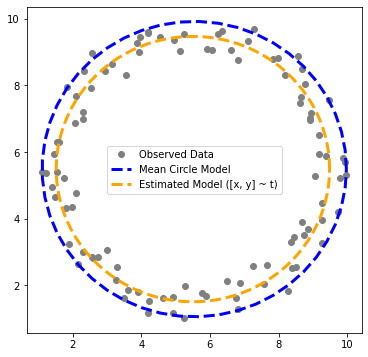

Model: f(t) = [ 5.505525270165683 + 3.9831872218085826 * cos(t), 5.488092437197259 + 3.9831872218085826 * sin(t) ]


In [33]:
cx, cy, rad = res_lsq['x']
circle_points = circle(t, cx, cy, rad)

fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o', color='grey', label='Observed Data')
plt.plot(mean_circle_points[0], mean_circle_points[1], '--', color='blue', lw=3, label='Mean Circle Model')
plt.plot(circle_points[0], circle_points[1], '--', color='orange', lw=3, label='Estimated Model ([x, y] ~ t)')
plt.legend()
plt.show()

print(f'Model: f(t) = [ {cx} + {rad} * cos(t), {cy} + {rad} * sin(t) ]')

## Example 2: Fitting a Nonlinear Function

Let's now look at another case where we may have to resort to using an optimisation method to help fit our model. Consider the following data:

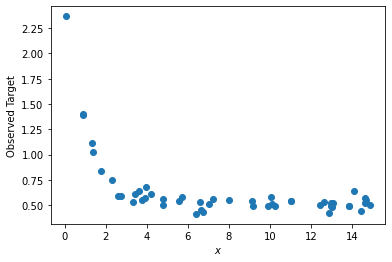

In [34]:
def gen_data(t, a, b, c, noise=0., n_outliers=0, rng=None):  ## function ripped straight from the scikit learn documentation :)
    if rng is None: rng = np.random.default_rng()

    y = a + b * np.exp(c * t)

    error = noise * rng.standard_normal(t.size)
    outliers = rng.integers(0, t.size, n_outliers)
    error[outliers] *= 10

    return y + error

a, b, c = 0.5, 2.0, -1

rng = np.random.default_rng(1234)
x_train = rng.uniform(0, 15, 50) ##np.linspace(0, 15, 25)
t_train = gen_data(x_train, a, b, c, noise=0.05, rng=rng)

plt.scatter(x_train, t_train)
plt.xlabel('$x$')
plt.ylabel('Observed Target')
plt.show()

As before, we wouldn't normally have the `gen_data` function, so we wouldn't know how the data was generated. However, the data follows a fairly clear shape, with strong non-linearity. A reasonable model to assume for this would be an _exponential_ model:
$$
f(x, a, b, c) = a + b \times e^{c\times t}
$$

To use this model, we need to fit the parameters $a$, $b$, and $c$ to minimise a cost function. As before, this will be to reduce the cost of the residuals of a model against out training data `t_train`. Let's start by defining a function to represent our exponential model.

**<span style="color: #ce2227;">TASK 2: </span>** Define a function `mdl` that takes four arguments, `x`, `a`, `b`, and `c`. This function will implement the model described above. To compute the exponential part of the model, use the numpy function `np.exp`:

In [35]:
def mdl(x, a, b, c):
    ouput =a + b * np.exp(c*x)
    return ouput

**<span style="color: #ce2227;">TASK 3: </span>** Define the residual function for our optimisation. The function, `residuals` takes four arguments - `theta` is the parameters that are being minimised in the optimisation (i.e., $a$, $b$, and $c$) all contained in a numpy array; `mdl` is the model function, and can be called as any function (e.g., `mdl(x, theta[0], theta[1], theta[2])`), and `x` and `t` are our training inputs and targets (respectively). The `residuals` function computes the difference between the supplied `t` and the predictions made by the model (i.e., $t - mdl\left(x, theta\right)$)

In [54]:
def residuals(theta, mdl, x, t):
    return t-  mdl(x, *theta)


If you have done everything correctly, then you should find that the following cell will optimise the parameters to our model to fit the data nicely:

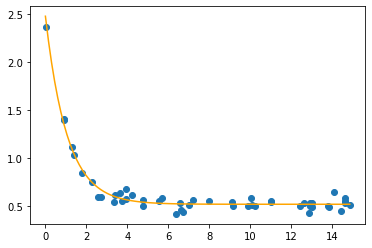

The estimated model parameters are: [ 0.51499947  1.95833184 -0.94295775] - the true parameters of the generating function were 0.5, 2.0, and -1.


In [55]:
res_lsq = least_squares(residuals, rng.normal(0, 1, 3), loss='huber', args=(mdl, x_train, t_train))

x_test = np.linspace(0, np.max(x_train), 100)
t_test = mdl(x_test, *res_lsq.x)

plt.scatter(x_train, t_train)
plt.plot(x_test, t_test, color='orange')
plt.show()

print(f'The estimated model parameters are: {res_lsq.x} - the true parameters of the generating function were {a}, {b}, and {c}.')

##  End of Lab 11.
Please remember to rename your completed notebook and submit it via Blackboard. 